# Preprocessing — přehled

1. Setup — imports & environment
2. Database — načtení `historical_posts` a `historical_comments`
3. Load tickers — načtení a normalizace seznamu tickerů
4. Data harmonization 
4.1 Sjednocení schémat do `df_unified`<br>
4.2 Spojení `title` + `body` pro posty <br>
5. EDA — overview, missingness, text length, top tickers, temporal <br>
5.1 Overview — counts & missingness<br>
5.2 Text characteristics<br>
5.3 Temporal analysis<br>
5.4 Engagement metrics<br>
5.5 Integrity and duplicates<br>
6. Data Cleaning — odstranění invalidních/prázdných záznamů
7. Feature engineering — text_length, word_count, temporal a engagement features
8. Ticker detection <br>
8.1 Detekce `mentioned_tickers`, `n_tickers`<br>
8.2 Ticker inheritance — inherit parent post tickers to comments<br>
9. Text normalization — tokenizace, lemmatizace, stopwords
10. Export — uložit `sentiment_ready_data.csv`

## 1 Setup — Imports & environment

Načteme potřebné knihovny a ověříme dostupnost spaCy/NLTK a DB driveru. To nám řekne, které nástroje můžeme použít dál pro čištění a tokenizaci textu.

In [1]:
# 1. Setup: Imports and Configuration

import pandas as pd
import numpy as np
import logging
import os
import re
import time
from datetime import datetime
from typing import List, Set, Dict, Any
from tqdm import tqdm
from io import StringIO
import urllib.request
import urllib.parse

# Environment and database imports
try:
    from dotenv import load_dotenv
    load_dotenv()
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False

try:
    import oracledb
    ORACLE_AVAILABLE = True
except ImportError:
    ORACLE_AVAILABLE = False
    print("Oracle DB not available. Install with: pip install oracledb")

# Checking for NLP libraries (if you lack any - install with pip install)
available_libs = []
try:
    import nltk
    NLTK_AVAILABLE = True
    available_libs.append("NLTK")
except ImportError:
    NLTK_AVAILABLE = False

try:
    import spacy
    SPACY_AVAILABLE = True
    available_libs.append("spaCy")
except ImportError:
    SPACY_AVAILABLE = False

# Import functions from utils
from utils import (
    get_oracle_connection,
    get_all_us_tickers,
    detect_tickers_in_text,
    apply_ticker_detection,
    harmonize_schema,
    drop_invalid_texts,
    deduplicate_and_normalize_types,
    add_temporal_features,
    add_engagement_features,
    apply_text_normalization,
    remove_financial_stopwords,
    remove_stopwords_spacy
)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Configuration constants for minimal text lenght of texts to be considered valid and retry delay for operations
MIN_TEXT_LENGTH = 10
RETRY_DELAY = 10

print(f"Step 1: imports loaded — available: {', '.join(available_libs) if available_libs else 'none'}")

Step 1: imports loaded — available: NLTK, spaCy


## 2 Database — Extract posts & comments

Připojíme se k databázi (nebo načteme z cache) a stáhneme posty a komentáře. 

In [2]:
# 2. Database Connection: Loading Reddit Data from Oracle

print("Step 2: importing Reddit data from Oracle database")

# Check if Oracle DB is available and credentials are set in environment variables
oracle_credentials_available = (
    ORACLE_AVAILABLE and 
    os.getenv('db-username') and 
    os.getenv('db-password') and
    os.getenv('db-dsn')
)

if oracle_credentials_available:
    print("Oracle credentials found, so far so good...")
    
    conn = get_oracle_connection()

    if conn:
        print("Database connection successful")
        
        # Importing data from database
        try:
            # Query to import posts (number of them is set to 5000 for testing, but can be set in the variable)
            query_posts = """
                SELECT 
                    author, title, created_utc, id, is_original_content,
                    score, DBMS_LOB.SUBSTR(body, 4000, 1) as body, 
                    subreddit, upvote_ratio, url
                FROM historical_posts 
                WHERE ROWNUM <= 5000
            """
            df_posts = pd.read_sql_query(query_posts, conn)
            
            # Query to import comments (number of them is set to 5000 for testing, but can be set in the variable)
            query_comments = """
                SELECT 
                    author, created_utc, id, parent_post_id, score,
                    DBMS_LOB.SUBSTR(body, 4000, 1) as body,
                    subreddit
                FROM historical_comments 
                WHERE ROWNUM <= 5000
            """
            df_comments = pd.read_sql_query(query_comments, conn)
            
            # Closing connection immediately after data import so that it does not stay open longer than needed
            conn.close()

            print(f"\nPosts imported: {df_posts.shape}")
            print(f"Comments imported: {df_comments.shape}")
            
            if len(df_posts) > 0:
                print(f"Posts columns: {list(df_posts.columns)}")
            
            if len(df_comments) > 0:
                print(f"Comments columns: {list(df_comments.columns)}")
                
        except Exception as e:
            print(f"Error importing data from database: {e}")
            if conn:
                try:
                    conn.close()
                except:
                    pass
            df_posts = pd.DataFrame()
            df_comments = pd.DataFrame()
            
    else:
        print("Failed to connect to database - check logs, kinda cooked you are")
        df_posts = pd.DataFrame()
        df_comments = pd.DataFrame()
        
else:
    print("Oracle database credentials not configured — set them in .env file or environment variables")
    df_posts = pd.DataFrame()
    df_comments = pd.DataFrame()

print(f"\nStep 2 complete: Loaded {len(df_posts)} posts and {len(df_comments)} comments. Letzgoo")

Step 2: importing Reddit data from Oracle database
Oracle credentials found, so far so good...
Oracle connection successful!
Database connection successful


/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_11401/373278453.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_posts = pd.read_sql_query(query_posts, conn)
/var/folders/33/r5z8ht2928103xc7s_sb_xx80000gq/T/ipykernel_11401/373278453.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comments = pd.read_sql_query(query_comments, conn)



Posts imported: (5000, 10)
Comments imported: (5000, 7)
Posts columns: ['AUTHOR', 'TITLE', 'CREATED_UTC', 'ID', 'IS_ORIGINAL_CONTENT', 'SCORE', 'BODY', 'SUBREDDIT', 'UPVOTE_RATIO', 'URL']
Comments columns: ['AUTHOR', 'CREATED_UTC', 'ID', 'PARENT_POST_ID', 'SCORE', 'BODY', 'SUBREDDIT']

Step 2 complete: Loaded 5000 posts and 5000 comments. Letzgoo


## 3 Load tickers — Ticker list & exchanges

Načteme a normalizujeme seznam tickerů (lokálně nebo ze zdroje)

In [3]:
# 3. Ticker Data Loading: Fetch NASDAQ/NYSE Symbols

# Check if we have cached ticker data
us_tickers_path = "us_tickers.csv"

if os.path.exists(us_tickers_path):
    try:
        tickers_df = pd.read_csv(us_tickers_path, dtype=str)
        # Normalizing column names (stripping spaces, lowercasing, replacing spaces with underscores)
        tickers_df.columns = [c.strip().lower().replace(" ", "_") for c in tickers_df.columns]
        if 'ticker' in tickers_df.columns:
            tickers_df['ticker'] = tickers_df['ticker'].astype(str).str.upper().str.strip()
        print(f"Loaded {len(tickers_df)} cached tickers")
    except Exception as e:
        print(f"Error loading cached data: {e}")
        tickers_df = None
else:
    tickers_df = None

# If no cached data or fresh data
if tickers_df is None or len(tickers_df) == 0:
    try:
        tickers_df = get_all_us_tickers()
        if len(tickers_df) > 0:
            tickers_df.to_csv(us_tickers_path, index=False)
            print(f"Fetched and cached {len(tickers_df)} US tickers")
        else:
            print("No ticker data retrieved - this should not happen xd")
    except Exception as e:
        print(f"Error fetching ticker data: {e}")
        tickers_df = pd.DataFrame()

if len(tickers_df) > 0:
    print(f"\nTicker data summary:")
    print(f"  Total tickers: {len(tickers_df)}")
    print(f"  Exchanges: {tickers_df['exchange'].value_counts().to_dict()}")
    
    # Check for major tickers - just to verify data integrity
    major_tickers = {'AAPL', 'TSLA', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'META'}
    found_major = set(tickers_df['ticker']) & major_tickers
    print(f"  Major tickers found: {found_major}")
    
else:
    print("No ticker data available - ur cooked bro")
    
print(f"\nStep 3 complete: Loaded {len(tickers_df)} ticker symbols. Letzgoo")

Loaded 8022 cached tickers

Ticker data summary:
  Total tickers: 8022
  Exchanges: {'NASDAQ': 5142, 'NYSE': 2880}
  Major tickers found: {'META', 'TSLA', 'GOOGL', 'MSFT', 'AMZN', 'NVDA', 'AAPL'}

Step 3 complete: Loaded 8022 ticker symbols. Letzgoo


## 4 Data harmonization — unify posts & comments

Sjednotíme posts a comments do jednoho `df_unified` s konzistentními sloupci (id, text, type, title, parent_post_id...). 

### 4.1 Unifying posts & comments

Sloučíme sloupce, přemapujeme názvy a vytvoříme jednotný sloupec `text`. 

In [4]:
# 4. Data Harmonization: Merge Posts and Comments (this is temporary solution)

if len(df_posts) > 0 or len(df_comments) > 0:
    # combining data
    df_unified = harmonize_schema(df_posts, df_comments)
    print(f"Unified dataframe shape: {df_unified.shape}")
    print(f"Unified columns: {list(df_unified.columns)}")
    
    # data type distribution
    type_counts = df_unified['type'].value_counts()
    print(f"\nData distribution:")
    for dtype, count in type_counts.items():
        print(f"  {dtype}: {count} rows")
    
else:
    print("No data to harmonize")
    df_unified = pd.DataFrame()

print(f"\nStep 4 complete: Unified {len(df_unified)} rows. Letzgoo")

/Users/simon2/Library/CloudStorage/OneDrive-Personal/UČENÍ/Textová analytika 2/stock-sentiment-analysis/utils.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unified = pd.concat([posts, comments], ignore_index=True, sort=False)
INFO:utils:Harmonized schema. Unified dataframe shape: (10000, 12)


Unified dataframe shape: (10000, 12)
Unified columns: ['author', 'title', 'created_utc', 'id', 'is_original_content', 'score', 'text', 'subreddit', 'upvote_ratio', 'url', 'parent_post_id', 'type']

Data distribution:
  post: 5000 rows
  comment: 5000 rows

Step 4 complete: Unified 10000 rows. Letzgoo


### 4.2 deleting [removed]/[deleted] placeholders 

This is done so later we dont get the reuslt like this: "Emotional investing research. [removed]"

In [5]:
# Clean/remove records with [removed]/[deleted] placeholders
def is_placeholder(s):
    if pd.isna(s):
        return True
    s = str(s).strip().lower()
    return s == '' or s in {'[deleted]', '[removed]'}

# Clean title/text placeholders (turn placeholders into empty string)
if 'title' in df_unified.columns:
    df_unified['title'] = df_unified['title'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())
if 'text' in df_unified.columns:
    df_unified['text'] = df_unified['text'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())

# Drop posts where both title and text are empty after cleaning
before = len(df_unified)
mask_empty_post = (df_unified['type'] == 'post') & (df_unified.get('title', '').astype(str).str.strip() == '') & (df_unified.get('text', '').astype(str).str.strip() == '')
mask_empty_comment = (df_unified['type'] == 'comment') & (df_unified.get('text', '').astype(str).str.strip() == '')
# For comments drop those with empty body; for posts drop only if both title+text empty
to_drop = mask_empty_post | mask_empty_comment
df_unified = df_unified[~to_drop].reset_index(drop=True)
after = len(df_unified)
print(f"We removed {before - after} placeholder-only rows (kept posts with title if present).")

We removed 128 placeholder-only rows (kept posts with title if present).


### 4.3 Merging title + body for posts

U postů spojíme `title` s tělem, protože titul často obsahuje klíčovou informaci nebo ticker. Zvýší to šanci, že detekce tickerů a sentimentu zachytí o čem post reálně je.

In [6]:
# 4.3 Enhanced Text: Merge Title + Body for Posts

if len(df_unified) > 0:
    
    # For posts: concatenate title + body
    # For comments: keep body only (no title)
    def create_enhanced_text(row):
        if row['type'] == 'post':
            title = str(row.get('title', '')).strip()
            body = str(row.get('text', '')).strip()
            # Combine title and body with separator
            if title and title != 'nan' and body and body != 'nan':
                return f"{title}. {body}"
            elif title and title != 'nan':
                return title
            elif body and body != 'nan':
                return body
            else:
                return ''
        else:
            # Comments: use text only
            return str(row.get('text', '')).strip()
    
    df_unified['enhanced_text'] = df_unified.apply(create_enhanced_text, axis=1)
    
    # Replace 'text' column with enhanced version
    df_unified['text'] = df_unified['enhanced_text']
    df_unified.drop(columns=['enhanced_text'], inplace=True)
    
    # We can safely rop title column since it's now merged into text (and later ticker detection is done on the "text" column)
    if 'title' in df_unified.columns:
        df_unified.drop(columns=['title'], inplace=True)
        print("Dropped 'title' column (merged into 'text')")
    
    print(f"Done")
    
else:
    print("No data to enhance")

Dropped 'title' column (merged into 'text')
Done


## 5 Exploratory Data Analysis (EDA)

Projdeme kvalitu dat a základní statistiky, abychom věděli jak data dál (pokud je to potřeba) upravit.

### 5.1 Overview — counts & missingness

Spočítáme počty, podíly chybějících hodnot a zjistíme, kolik záznamů je smazaných nebo prázdných. 

In [7]:
# 5.1 Data Quality & Completeness

if len(df_unified) > 0:

    # Missing values analysis
    print(f"\nNAs by Column:")
    for col in df_unified.columns:
        missing_count = df_unified[col].isna().sum()
        missing_perct = (missing_count / len(df_unified)) * 100
        if missing_count > 0:
            print(f"  {col}: {missing_count:,} ({missing_perct:.1f}%)")
    
    # Check for deleted/removed content
    if 'text' in df_unified.columns:
        deleted_removed = df_unified['text'].isin(['[deleted]', '[removed]']).sum()
        print(f"\nDeleted/Removed Content:")
        print(f"  Count: {deleted_removed:,} ({deleted_removed/len(df_unified)*100:.1f}%)")
        
        # Empty or very short texts
        empty_texts = (df_unified['text'].isna() | (df_unified['text'] == '')).sum()
        very_short = (df_unified['text'].astype(str).str.len() <= 5).sum()
        print(f"  Empty texts: {empty_texts:,}")
        print(f"  Very short (≤5 chars): {very_short:,}")
    
    # Subreddit distribution
    if 'subreddit' in df_unified.columns:
        subreddit_counts = df_unified['subreddit'].value_counts()
        print(f"\nSubreddit Distribution:")
        print(f"  Unique subreddits: {df_unified['subreddit'].nunique()}")
        print(f"  Top 5 subreddits:")
        for subreddit, count in subreddit_counts.head(5).items():
            pct = (count / len(df_unified)) * 100
            print(f"    {subreddit}: {count:,} ({pct:.1f}%)")
    
    # Content type distribution
    if 'type' in df_unified.columns:
        type_dist = df_unified['type'].value_counts()
        print(f"\nContent Type Distribution:")
        for content_type, count in type_dist.items():
            pct = (count / len(df_unified)) * 100
            print(f"  {content_type}: {count:,} ({pct:.1f}%)")
    
    print()
else:
    print("No data available for quality analysis. Well fuck")


NAs by Column:
  is_original_content: 4,872 (49.4%)
  upvote_ratio: 4,872 (49.4%)
  url: 4,906 (49.7%)
  parent_post_id: 5,000 (50.6%)

Deleted/Removed Content:
  Count: 0 (0.0%)
  Empty texts: 0
  Very short (≤5 chars): 104

Subreddit Distribution:
  Unique subreddits: 3
  Top 5 subreddits:
    investing: 6,319 (64.0%)
    ValueInvesting: 2,118 (21.5%)
    stocks: 1,435 (14.5%)

Content Type Distribution:
  post: 5,000 (50.6%)
  comment: 4,872 (49.4%)



Všechno je v pořádku — chybějící hodnoty jsou strukturální (posty vs. komentáře mají různé sloupce). <br>
Very short texts (≤5 chars): 104 — ty budou odstraněny v kroku 6 (drop_invalid_texts). <br>
Ztráta 128 rows — prázdné/smazané komentáře dropnuty v kroku 4.2. <br>

### 5.2 Text characteristics

Podíváme se na délky textů, počty slov a percentily, abychom kdyžtak vyfiltrovali moc krátký/dlouhý (spíš ne).


Word Count Statistics (Overall):
  Mean: 55.3 words
  Median: 20.0 words
  Min: 1 words
  Max: 763 words

Word Count Distribution (histograms):


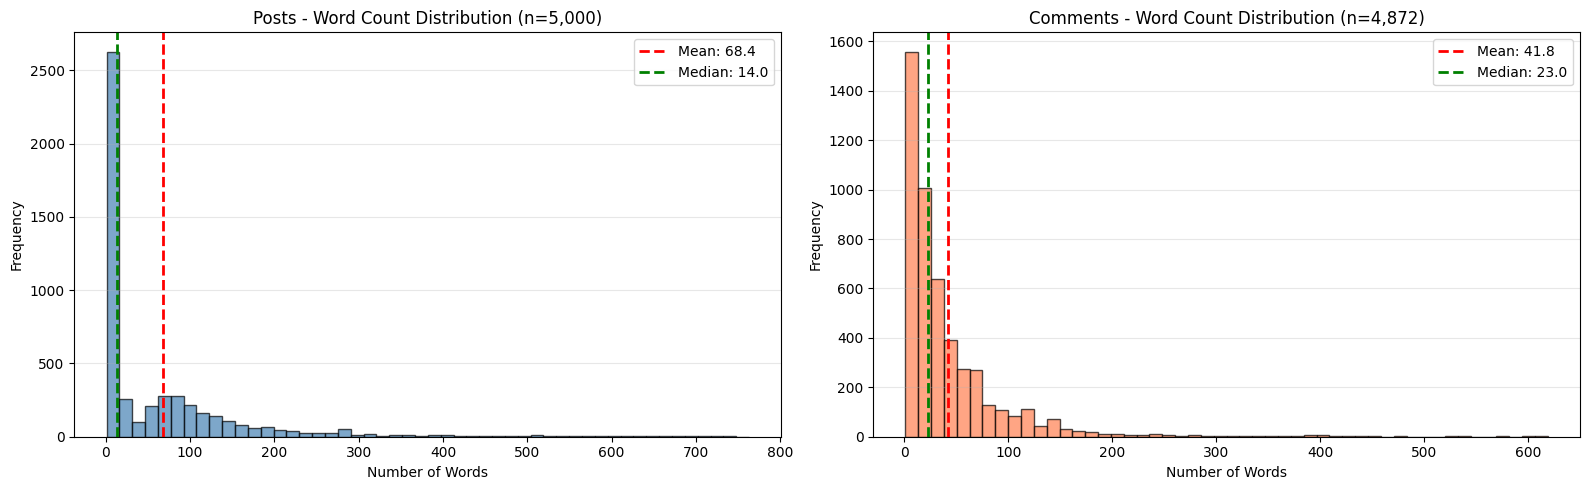


Quality Issues:
  Texts ≤10 chars: 197 (2.0%)


In [15]:
# 5.2 Text Characteristics

if len(df_unified) > 0 and 'text' in df_unified.columns:
    
    # Calculate text statistics
    valid_texts = df_unified[df_unified['text'].notna() & (df_unified['text'] != '')]
    
    if len(valid_texts) > 0:
        # Text length statistics
        text_lengths = valid_texts['text'].astype(str).str.len()
        
        # Word count statistics
        word_counts = valid_texts['text'].astype(str).str.split().str.len()
        
        print(f"\nWord Count Statistics (Overall):")
        print(f"  Mean: {word_counts.mean():.1f} words")
        print(f"  Median: {word_counts.median():.1f} words")
        print(f"  Min: {word_counts.min()} words")
        print(f"  Max: {word_counts.max()} words")
        
        # Visualize word count distribution (separate for posts and comments)
        print(f"\nWord Count Distribution (histograms):")
        try:
            import matplotlib.pyplot as plt
            
            if 'type' in valid_texts.columns and len(posts) > 0 and len(comments) > 0:
                # Create side-by-side histograms
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
                
                # Posts histogram
                ax1.hist(post_word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
                ax1.axvline(post_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {post_word_counts.mean():.1f}')
                ax1.axvline(post_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {post_word_counts.median():.1f}')
                ax1.set_xlabel('Number of Words')
                ax1.set_ylabel('Frequency')
                ax1.set_title(f'Posts - Word Count Distribution (n={len(posts):,})')
                ax1.legend()
                ax1.grid(axis='y', alpha=0.3)
                
                # Comments histogram
                ax2.hist(comment_word_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
                ax2.axvline(comment_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comment_word_counts.mean():.1f}')
                ax2.axvline(comment_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {comment_word_counts.median():.1f}')
                ax2.set_xlabel('Number of Words')
                ax2.set_ylabel('Frequency')
                ax2.set_title(f'Comments - Word Count Distribution (n={len(comments):,})')
                ax2.legend()
                ax2.grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
            else:
                # Fallback: single histogram if no type column
                plt.figure(figsize=(10, 5))
                plt.hist(word_counts, bins=50, edgecolor='black', alpha=0.7)
                plt.xlabel('Number of Words')
                plt.ylabel('Frequency')
                plt.title('Distribution of Word Counts in Texts')
                plt.axvline(word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {word_counts.mean():.1f}')
                plt.axvline(word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {word_counts.median():.1f}')
                plt.legend()
                plt.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                plt.show()
            
        except ImportError:
            print("  matplotlib not available - install with: pip install matplotlib")
        
        # Short texts identification
        very_short = (text_lengths <= MIN_TEXT_LENGTH).sum()
        print(f"\nQuality Issues:")
        print(f"  Texts ≤{MIN_TEXT_LENGTH} chars: {very_short:,} ({very_short/len(valid_texts)*100:.1f}%)")
        
else:
    print("No text data")

### 5.3 Temporal analysis

Zkontrolujeme časové rozložení příspěvků (denní/hodinové špičky a rozsah dat). To zajímá jen mě, nejspíš to nebude důležitý, but u never know.


Date Range:
  Earliest: 2024-02-03 13:20:21
  Latest: 2024-11-13 23:17:45
  Span: 284 days

Daily Activity:
  Mean posts per day: 80.9
  Median posts per day: 36.0
  Max posts in a day: 640
  Min posts in a day: 2

Day of Week Distribution:
  Monday: 1,301 (13.2%)
  Tuesday: 1,565 (15.9%)
  Wednesday: 2,010 (20.4%)
  Thursday: 1,379 (14.0%)
  Friday: 1,223 (12.4%)
  Saturday: 972 (9.8%)
  Sunday: 1,422 (14.4%)

Temporal Distribution Charts:


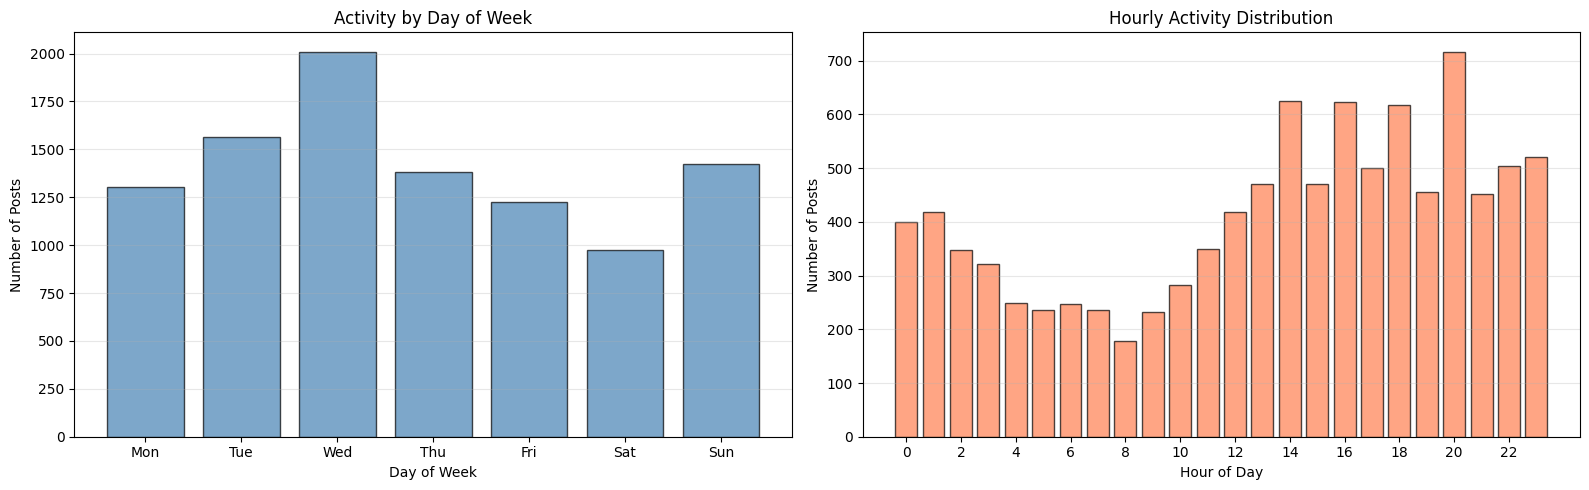

In [22]:
# 5.3 Temporal Analysis

if len(df_unified) > 0 and 'created_utc' in df_unified.columns:
    
    # Convert to datetime
    valid_dates = df_unified[df_unified['created_utc'].notna()].copy()
    
    if len(valid_dates) > 0:
        valid_dates['datetime'] = pd.to_datetime(valid_dates['created_utc'], unit='s')
        
        # Date range
        print(f"\nDate Range:")
        print(f"  Earliest: {valid_dates['datetime'].min()}")
        print(f"  Latest: {valid_dates['datetime'].max()}")
        print(f"  Span: {(valid_dates['datetime'].max() - valid_dates['datetime'].min()).days} days")
        
        # Extract temporal features
        valid_dates['date'] = valid_dates['datetime'].dt.date
        valid_dates['hour'] = valid_dates['datetime'].dt.hour
        valid_dates['day_of_week'] = valid_dates['datetime'].dt.day_name()
        valid_dates['month'] = valid_dates['datetime'].dt.month
        
        # Posts per day statistics
        daily_counts = valid_dates.groupby('date').size()
        print(f"\nDaily Activity:")
        print(f"  Mean posts per day: {daily_counts.mean():.1f}")
        print(f"  Median posts per day: {daily_counts.median():.1f}")
        print(f"  Max posts in a day: {daily_counts.max()}")
        print(f"  Min posts in a day: {daily_counts.min()}")
        
        # Day of week distribution
        print(f"\nDay of Week Distribution:")
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        day_counts = valid_dates['day_of_week'].value_counts()
        for day in day_order:
            if day in day_counts.index:
                count = day_counts[day]
                pct = (count / len(valid_dates)) * 100
                print(f"  {day}: {count:,} ({pct:.1f}%)")

        
        # Visualize temporal patterns
        print(f"\nTemporal Distribution Charts:")
        try:
            import matplotlib.pyplot as plt
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
            
            # Chart 1: Day of week distribution (bar chart)
            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            day_counts_ordered = [day_counts.get(day, 0) for day in day_order]
            ax1.bar(range(7), day_counts_ordered, color='steelblue', alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Day of Week')
            ax1.set_ylabel('Number of Posts')
            ax1.set_title('Activity by Day of Week')
            ax1.set_xticks(range(7))
            ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            ax1.grid(axis='y', alpha=0.3)
            
            # Chart 2: Hourly distribution (bar chart)
            hours = list(range(24))
            counts = [hour_counts.get(h, 0) for h in hours]
            ax2.bar(hours, counts, color='coral', alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Hour of Day')
            ax2.set_ylabel('Number of Posts')
            ax2.set_title('Hourly Activity Distribution')
            ax2.set_xticks(range(0, 24, 2))
            ax2.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except ImportError:
            print("  matplotlib not available - install with: pip install matplotlib")
    
    print()
else:
    print("Warning: No temporal data available for analysis")

### 5.4 Engagement metrics

Analyzujeme skóre/upvote_ratio a další metriky engagementu -> identifikace populárních příspěvku.


Score Distribution:
  Mean: 6.18, Median: 1.00
  Min: -87, Max: 1468
  25th percentile: 1, 75th percentile: 2

Score by Content Type:
  Posts: mean=7.59, median=1.00
  Comments: mean=4.72, median=1.00

Upvote Ratio (Posts): mean=0.834, median=1.000

Engagement Charts:


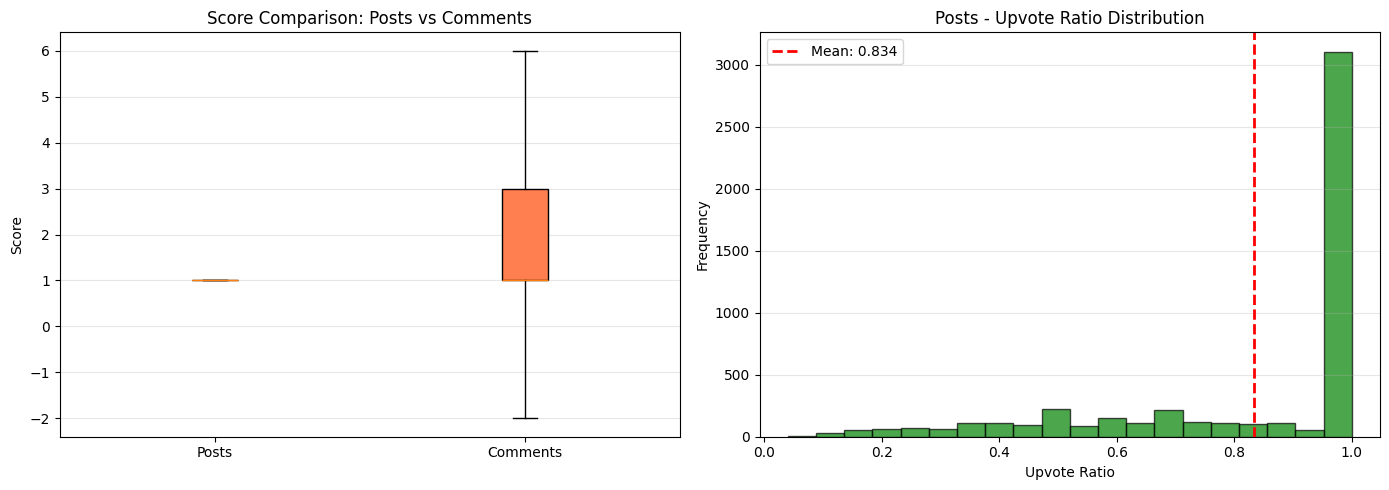

In [26]:
# 5.4 Engagement Metrics

if len(df_unified) > 0:
    
    # Score analysis
    if 'score' in df_unified.columns:
        valid_scores = df_unified[df_unified['score'].notna()]
        
        if len(valid_scores) > 0:
            print(f"\nScore Distribution:")
            print(f"  Mean: {valid_scores['score'].mean():.2f}, Median: {valid_scores['score'].median():.2f}")
            print(f"  Min: {valid_scores['score'].min()}, Max: {valid_scores['score'].max()}")
            print(f"  25th percentile: {valid_scores['score'].quantile(0.25):.0f}, 75th percentile: {valid_scores['score'].quantile(0.75):.0f}")
    
    # Score by content type
    if 'score' in df_unified.columns and 'type' in df_unified.columns:
        print(f"\nScore by Content Type:")
        posts = df_unified[df_unified['type'] == 'post']
        comments = df_unified[df_unified['type'] == 'comment']
        
        if len(posts) > 0 and 'score' in posts.columns:
            post_scores = posts['score'].dropna()
            print(f"  Posts: mean={post_scores.mean():.2f}, median={post_scores.median():.2f}")
        
        if len(comments) > 0 and 'score' in comments.columns:
            comment_scores = comments['score'].dropna()
            print(f"  Comments: mean={comment_scores.mean():.2f}, median={comment_scores.median():.2f}")
    
    # Upvote ratio (for posts)
    if 'upvote_ratio' in df_unified.columns:
        valid_ratios = df_unified[df_unified['upvote_ratio'].notna()]
        if len(valid_ratios) > 0:
            print(f"\nUpvote Ratio (Posts): mean={valid_ratios['upvote_ratio'].mean():.3f}, median={valid_ratios['upvote_ratio'].median():.3f}")
    
    # Visualizations
    print(f"\nEngagement Charts:")
    try:
        import matplotlib.pyplot as plt
        
        if 'score' in df_unified.columns and 'type' in df_unified.columns:
            posts = df_unified[df_unified['type'] == 'post']
            comments = df_unified[df_unified['type'] == 'comment']
            
            if len(posts) > 0 and len(comments) > 0:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
                
                # Chart 1: Box plot comparison (Posts vs Comments)
                post_scores = posts['score'].dropna()
                comment_scores = comments['score'].dropna()
                
                score_data = []
                labels = []
                if len(post_scores) > 0:
                    score_data.append(post_scores)
                    labels.append('Posts')
                if len(comment_scores) > 0:
                    score_data.append(comment_scores)
                    labels.append('Comments')
                
                if len(score_data) > 0:
                    bp = ax1.boxplot(score_data, labels=labels, patch_artist=True, showfliers=False)
                    bp['boxes'][0].set_facecolor('steelblue')
                    if len(bp['boxes']) > 1:
                        bp['boxes'][1].set_facecolor('coral')
                    ax1.set_ylabel('Score')
                    ax1.set_title('Score Comparison: Posts vs Comments')
                    ax1.grid(axis='y', alpha=0.3)
                
                # Chart 2: Upvote ratio distribution (for posts)
                if 'upvote_ratio' in posts.columns:
                    upvote_ratios = posts['upvote_ratio'].dropna()
                    if len(upvote_ratios) > 0:
                        ax2.hist(upvote_ratios, bins=20, edgecolor='black', alpha=0.7, color='green')
                        ax2.axvline(upvote_ratios.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {upvote_ratios.mean():.3f}')
                        ax2.set_xlabel('Upvote Ratio')
                        ax2.set_ylabel('Frequency')
                        ax2.set_title(f'Posts - Upvote Ratio Distribution')
                        ax2.legend()
                        ax2.grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
        
    except ImportError:
        print("  matplotlib not available - install with: pip install matplotlib")
    
    print()
else:
    print("Warning: No data available for engagement analysis")

### 5.5 Integrity and duplicates

Najdeme duplicitní ID a další integrity problémy (chybějící ID, extrémně krátké texty).

In [ ]:
# 5.5 Data Integrity & Duplicates

if len(df_unified) > 0:
    
    # Duplicate IDs
    if 'id' in df_unified.columns:
        print(f"\nID Uniqueness:")
        total_ids = len(df_unified)
        unique_ids = df_unified['id'].nunique()
        duplicate_ids = total_ids - unique_ids
        
        print(f"  Total rows: {total_ids:,}")
        print(f"  Unique IDs: {unique_ids:,}")
        print(f"  Duplicate IDs: {duplicate_ids:,} ({duplicate_ids/total_ids*100:.2f}%)")
        
        if duplicate_ids > 0:
            # Show most duplicated IDs
            dup_counts = df_unified['id'].value_counts()
            most_duplicated = dup_counts[dup_counts > 1].head(5)
            print(f"\n  Most duplicated IDs:")
            for id_val, count in most_duplicated.items():
                print(f"    {id_val}: appears {count} times")
    
    # Author analysis
    if 'author' in df_unified.columns:
        print(f"\nAuthor Statistics:")
        author_data = df_unified[df_unified['author'].notna()]
        unique_authors = author_data['author'].nunique()
        
        print(f"  Posts with author: {len(author_data):,} / {len(df_unified):,}")
        print(f"  Unique authors: {unique_authors:,}")
        
        if len(author_data) > 0:
            posts_per_author = author_data.groupby('author').size()
            print(f"  Mean posts per author: {posts_per_author.mean():.1f}")
            print(f"  Median posts per author: {posts_per_author.median():.1f}")
            
            # Top contributors
            print(f"\n  Top 5 contributors:")
            for author, count in posts_per_author.nlargest(5).items():
                print(f"    {author}: {count:,} posts")
    
    # Check for potential issues
    print(f"\nPotential Data Issues:")
    issues_found = 0
    
    # Check for NaN in critical fields
    critical_fields = ['id', 'text', 'created_utc']
    for field in critical_fields:
        if field in df_unified.columns:
            na_count = df_unified[field].isna().sum()
            if na_count > 0:
                print(f"  Warning {field}: {na_count:,} missing values")
                issues_found += 1
    
    # Check for deleted/removed content
    if 'text' in df_unified.columns:
        deleted = df_unified['text'].isin(['[deleted]', '[removed]']).sum()
        if deleted > 0:
            print(f"  Warning: Deleted/removed content: {deleted:,} rows")
            issues_found += 1
    
    # Check for extremely short texts
    if 'text' in df_unified.columns:
        very_short = (df_unified['text'].astype(str).str.len() <= 5).sum()
        if very_short > 0:
            print(f"  Warning: Extremely short texts (≤5 chars): {very_short:,} rows")
            issues_found += 1
    
    if issues_found == 0:
        print("No major data quality issues detected")
    
    # Summary
    print(f"\nEDA Summary:")
    print(f"  Total data points: {len(df_unified):,}")
    
    # Calculate data quality score
    quality_issues = 0
    if 'text' in df_unified.columns:
        invalid_text = (
            df_unified['text'].isna() | 
            df_unified['text'].isin(['[deleted]', '[removed]', '']) |
            (df_unified['text'].astype(str).str.len() <= MIN_TEXT_LENGTH)
        ).sum()
        quality_issues = invalid_text
    
    if 'id' in df_unified.columns:
        quality_issues += (total_ids - unique_ids)
    
    valid_rows = len(df_unified) - quality_issues
    quality_score = (valid_rows / len(df_unified)) * 100
    
    print(f"  Estimated valid rows: {valid_rows:,} ({quality_score:.1f}%)")
    print(f"  Rows needing cleaning: {quality_issues:,} ({100-quality_score:.1f}%)")
    
else:
    print("No data available for integrity analysis")


ID Uniqueness:
  Total rows: 9,872
  Unique IDs: 9,872
  Duplicate IDs: 0 (0.00%)

Author Statistics:
  Posts with author: 9,872 / 9,872
  Unique authors: 6,726
  Mean posts per author: 1.5
  Median posts per author: 1.0

  Top 5 contributors:
    AutoModerator: 212 posts
    RubFormer3559: 51 posts
    a-pilot: 35 posts
    [deleted]: 34 posts
    raytoei: 26 posts

Potential Data Issues:

EDA Summary:
  Total data points: 9,872
  Estimated valid rows: 9,675 (98.0%)
  Rows needing cleaning: 197 (2.0%)

EDA Complete - Ready for data cleaning



## 6. Data Cleaning

Odstraníme smazané a prázdné texty, doplníme nebo ošetříme NA a odfiltrujeme příliš krátké záznamy. 

In [ ]:
# 6. Data Cleaning: Remove Invalid and Duplicate Content

if len(df_unified) > 0:
    print(f"Starting with {len(df_unified)} rows")
    
    # Step 6a: Remove invalid texts
    df_cleaned = drop_invalid_texts(df_unified, min_len=MIN_TEXT_LENGTH)
    print(f"    After removing invalid texts: {len(df_cleaned)} rows (-{len(df_unified) - len(df_cleaned)})")
    
    # Step 6b: Deduplicate and normalize types
    df_cleaned = deduplicate_and_normalize_types(df_cleaned)
    print(f"    After deduplication: {len(df_cleaned)} rows")

    # Step 6c: Droping unnecessary columns (url, is_original_content)
    columns_to_drop = ['url', 'is_original_content']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
    if existing_cols_to_drop:
        df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
        print(f"    Dropped columns: {existing_cols_to_drop}")
    
    # Show cleaning results
    if len(df_cleaned) > 0:
        print(f"  Original rows: {len(df_unified)}")
        print(f"  Cleaned rows: {len(df_cleaned)}")
        print(f"  Removed: {len(df_unified) - len(df_cleaned)} ({((len(df_unified) - len(df_cleaned))/len(df_unified)*100):.1f}%)")
        
        # Show data types after cleaning
        print(f"\nData types after cleaning:")
        type_counts = df_cleaned['type'].value_counts()
        for dtype, count in type_counts.items():
            print(f"  {dtype}: {count} rows")
    else:
        print("No data remaining after cleaning.")
        
else:
    print("No data to clean")
    df_cleaned = pd.DataFrame()

print(f"\nStep 6 complete: {len(df_cleaned)} clean rows")

## 7. Feature engineering

Přidáme užitečné sloupce (text_length, word_count, časové atributy, engagement features). Tyhle featury budeme používat při analýze a modelování.

In [ ]:
# 7. Feature Engineering: Add Temporal and Engagement Features

if len(df_cleaned) > 0:
    df_features = add_temporal_features(df_cleaned)
    df_features = add_engagement_features(df_features)
    
    print(f"Enhanced dataframe shape: {df_features.shape}")
    
    # new features
    new_features = ['date', 'hour', 'day_of_week', 'month', 'is_weekend', 
                   'text_length', 'word_count', 'score_log1p']
    print(f"\nNew features added: {[f for f in new_features if f in df_features.columns]}")
    
    # Show feature statistics
    if 'text_length' in df_features.columns:
        print(f"  Text length: min={df_features['text_length'].min()}, "
              f"mean={df_features['text_length'].mean():.1f}, "
              f"max={df_features['text_length'].max()}")
    
    if 'word_count' in df_features.columns:
        print(f"  Word count: min={df_features['word_count'].min()}, "
              f"mean={df_features['word_count'].mean():.1f}, "
              f"max={df_features['word_count'].max()}")
    
    if 'day_of_week' in df_features.columns:
        day_counts = df_features['day_of_week'].value_counts()
        print(f"  Day distribution: {day_counts.to_dict()}")
    
    if 'is_weekend' in df_features.columns:
        weekend_pct = df_features['is_weekend'].mean() * 100
        print(f"  Weekend posts: {weekend_pct:.1f}%")
    
else:
    print("No data for feature engineering")
    df_features = pd.DataFrame()

print(f"\nStep 7 complete: {len(df_features)} rows with enhanced features")

## 8. Ticker detection

Detekujeme tickery v textu podle načteného seznamu a uložíme je do `mentioned_tickers` a `n_tickers`. Chceme vědět, o které akcie se mluví v jednotlivých záznamech.

### 8.1 Identifying Stock Ticker Mentions

In [ ]:
# 8. Ticker Detection: Identify Stock Ticker Mentions

if len(df_features) > 0 and len(tickers_df) > 0:
    print(f"Detecting tickers in {len(df_features)} texts using {len(tickers_df)} symbols")
    
    # improved ticker detection
    df_with_tickers = apply_ticker_detection(df_features, tickers_df)
    
    # results
    ticker_stats = df_with_tickers['n_tickers'].value_counts().sort_index()
    total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
    print(f"  Total rows: {len(df_with_tickers)}")
    print(f"  Rows with tickers: {total_with_tickers} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")
    print(f"  Rows without tickers: {len(df_with_tickers) - total_with_tickers}")
    
    print(f"\nTicker count distribution:")
    for count, rows in ticker_stats.head(10).items():
        print(f"  {count} tickers: {rows} rows")
    
    # Show if any tickers were found
    ticker_examples = df_with_tickers[df_with_tickers['n_tickers'] > 0]
    if len(ticker_examples) > 0:
        print(f"\nTicker detection successful: Found {len(ticker_examples)} rows with ticker mentions")
    else:
        print(f"\nNo tickers detected - this indicates high precision (no false positives)")
        print("Testing detection with synthetic examples:")
        
        # Test with known ticker-rich text (projistotu)
        ticker_set = set(tickers_df['ticker'])
        test_texts = [
            "I'm buying $AAPL and TSLA today",
            "MSFT and GOOGL are performing well",
            "Just some random text without tickers"
        ]
        
        for test_text in test_texts:
            detected = detect_tickers_in_text(test_text, ticker_set)
            print(f"    '{test_text}' → {detected}")
    
else:
    print("No data or tickers available for detection")
    df_with_tickers = pd.DataFrame()

print(f"\nStep 8 complete: Processed {len(df_with_tickers)} rows for ticker detection")

### 8.5 Ticker inheritance — Comments inherit parent post tickers

Pokud komentář nemá zmíněný ticker, vezmeme tickery z rodičovského postu a spojíme je (union). Tím zlepšíme pokrytí tickerů u komentářů, které odkazují na post bez přesný zmínky.

In [ ]:
# 8.5 Ticker Inheritance from Parent Posts

if len(df_with_tickers) > 0:
    print("\n8.5 Inheriting tickers from parent posts to comments...")
    
    # Build post ticker map: post_id -> set of tickers
    posts = df_with_tickers[df_with_tickers['type'] == 'post'].copy()
    post_ticker_map = {}
    
    for _, row in posts.iterrows():
        post_id = row['id']
        tickers_str = row.get('mentioned_tickers', '')
        if pd.notna(tickers_str) and tickers_str:
            tickers = set(tickers_str.split(','))
            post_ticker_map[post_id] = tickers
    
    # Inherit tickers to comments
    def inherit_parent_tickers(row):
        if row['type'] == 'comment':
            parent_id = row.get('parent_post_id')
            if pd.notna(parent_id) and parent_id in post_ticker_map:
                # Get comment's own tickers
                own_tickers = set()
                if pd.notna(row.get('mentioned_tickers')) and row['mentioned_tickers']:
                    own_tickers = set(row['mentioned_tickers'].split(','))
                
                # Merge with parent tickers (set union)
                parent_tickers = post_ticker_map[parent_id]
                merged_tickers = own_tickers.union(parent_tickers)
                
                return ','.join(sorted(merged_tickers)) if merged_tickers else ''
        
        # For posts or comments without parent: keep original
        return row.get('mentioned_tickers', '')
    
    df_with_tickers['mentioned_tickers'] = df_with_tickers.apply(inherit_parent_tickers, axis=1)
    
    # Recalculate n_tickers
    df_with_tickers['n_tickers'] = df_with_tickers['mentioned_tickers'].apply(
        lambda x: len(x.split(',')) if pd.notna(x) and x else 0
    )
    
    # Show impact
    comments = df_with_tickers[df_with_tickers['type'] == 'comment']
    comments_with_tickers = comments[comments['n_tickers'] > 0]
    
    print(f"  Total comments: {len(comments)}")
    print(f"  Comments with tickers (after inheritance): {len(comments_with_tickers)}")
    print(f"  Coverage: {len(comments_with_tickers) / len(comments) * 100:.1f}%")
    
    print("\nStep 8.5 complete: Ticker inheritance applied to comments")
else:
    print("No data to process")

## 9. Text normalization

Připravíme text pro sentiment a modely (tokenizace, lemmatizace, odstranění stopwords). 

In [ ]:
# 9. Text Normalization: Prepare Text for Sentiment Analysis

if len(df_with_tickers) > 0:

    # Basic text normalization (creates 'sentiment_ready_text' column)
    df_final = apply_text_normalization(df_with_tickers, keep_tickers=True)
    
    # Apply additional stopword removal to improve the text further
    
    if SPACY_AVAILABLE:
        print("Using spaCy")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_stopwords_spacy(x, preserve_tickers=True)
        )
        stopword_method = "spaCy"
    elif NLTK_AVAILABLE:
        print("Using NLTK")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=True)
        )
        stopword_method = "NLTK"
    else:
        print("Using built-in stopword removal (basic)")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=True)
        )
        stopword_method = "Built-in"
    
    print(f"Text normalization complete using {stopword_method}")
    print(f"Final dataframe shape: {df_final.shape}")
    print(f"Final columns: {list(df_final.columns)}")
    
    # Final statistics
    print(f"\nFinal dataset statistics:")
    print(f"  Total rows: {len(df_final)}")
    print(f"  Rows with tickers: {(df_final['n_tickers'] > 0).sum()}")
    print(f"  Average original text length: {df_final['text_length'].mean():.1f} characters")
    print(f"  Average word count: {df_final['word_count'].mean():.1f} words")
    
    # Show text processing impact
    avg_original_length = df_final['text'].str.len().mean()
    avg_sentiment_ready_length = df_final['sentiment_ready_text'].str.len().mean()
    
    print(f"\nimpact:")
    print(f"  Original text length: {avg_original_length:.1f} chars")
    print(f"  Sentiment-ready text length: {avg_sentiment_ready_length:.1f} chars")
    print(f"  Reduction from normalization: {((avg_original_length - avg_sentiment_ready_length) / avg_original_length * 100):.1f}%")
    print(f"  Stopword removal method: {stopword_method}")
    
    if 'type' in df_final.columns:
        type_dist = df_final['type'].value_counts()
        print(f"  Content distribution: {type_dist.to_dict()}")
    
else:
    print("No data for text normalization")
    df_final = pd.DataFrame()

print(f"\nStep 9 complete: {len(df_final)} rows ready for sentiment analysis.")

## 10. Exporting results

Uložíme finální dataset s připraveným textem a featurami (CSV). 

In [ ]:
# 10. Export Results: Save Sentiment-Ready Data

if len(df_final) > 0:
    print(f"Available columns: {list(df_final.columns)}")
    
    # Export to CSV 
    output_file = "sentiment_ready_data.csv"
    
    # Updated key columns including exchange information
    sentiment_columns = [
        'id', 'text', 'sentiment_ready_text', 'type', 'subreddit', 
        'created_utc', 'score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges',
        'text_length', 'word_count', 'date', 'hour', 'day_of_week']
    
    # Keep only columns that exist
    export_columns = [col for col in sentiment_columns if col in df_final.columns]
    export_df = df_final[export_columns].copy()
    
    # Save to CSV
    export_df.to_csv(output_file, index=False)
    print(f"Exported {len(export_df)} rows to {output_file}")
    print(f"Exported columns: {export_columns}")
    
    # Show exchange distribution
    if 'ticker_exchanges' in export_df.columns:
        exchange_dist = export_df[export_df['ticker_exchanges'] != '']['ticker_exchanges'].value_counts()
        print(f"\nExchange distribution (rows with tickers):")
        for exchange, count in exchange_dist.items():
            print(f"  {exchange}: {count} rows")
    
    print(f"\nData is ready for sentiment analysis")
    print(f"Use the 'sentiment_ready_text' column for sentiment modeling")
    print(f"Use the 'mentioned_tickers' column for ticker information")
    print(f"Use the 'ticker_exchanges' column for exchange information (NYSE/NASDAQ/BOTH)")
    
else:
    print("No data to export")

print(f"\nStep 10 complete: Preprocessing pipeline complete.")